In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import matplotlib.pyplot as plt


In [3]:
df = pd.read_csv('S05-hw-dataset.csv')

In [7]:
# первые строки датасета
print(df.head())

   client_id  age  income  years_employed  credit_score  debt_to_income  \
0          1   25   94074              22           839        0.547339   
1          2   58   51884              26           565        0.290882   
2          3   53   48656              39           561        0.522340   
3          4   42   81492              30           582        0.709123   
4          5   42   94713               8           642        0.793392   

   num_credit_cards  num_late_payments  has_mortgage  has_car_loan  \
0                 1                  7             0             0   
1                 1                  1             0             1   
2                 1                 13             0             0   
3                 2                 10             1             1   
4                 3                  3             0             0   

   savings_balance  checking_balance  region_risk_score  \
0            26057              5229           0.080052   
1         

In [9]:
# информация о столбцах и типах
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   client_id                       3000 non-null   int64  
 1   age                             3000 non-null   int64  
 2   income                          3000 non-null   int64  
 3   years_employed                  3000 non-null   int64  
 4   credit_score                    3000 non-null   int64  
 5   debt_to_income                  3000 non-null   float64
 6   num_credit_cards                3000 non-null   int64  
 7   num_late_payments               3000 non-null   int64  
 8   has_mortgage                    3000 non-null   int64  
 9   has_car_loan                    3000 non-null   int64  
 10  savings_balance                 3000 non-null   int64  
 11  checking_balance                3000 non-null   int64  
 12  region_risk_score               30

In [11]:
# базовые описательные статистики
print(df.describe())

         client_id          age         income  years_employed  credit_score  \
count  3000.000000  3000.000000    3000.000000     3000.000000   3000.000000   
mean   1500.500000    45.059667   69658.992000       19.577667    649.285333   
std     866.169729    14.192883   24742.235182       11.381497     69.955852   
min       1.000000    21.000000   15000.000000        0.000000    402.000000   
25%     750.750000    33.000000   52641.750000       10.000000    604.000000   
50%    1500.500000    45.000000   69784.500000       20.000000    647.000000   
75%    2250.250000    57.000000   85874.250000       29.000000    697.000000   
max    3000.000000    69.000000  156351.000000       39.000000    850.000000   

       debt_to_income  num_credit_cards  num_late_payments  has_mortgage  \
count     3000.000000       3000.000000        3000.000000   3000.000000   
mean         0.284065          3.494667           6.869333      0.495000   
std          0.161112          2.289917           4

In [21]:
#распределение целевого признака default
target_distribution = df['default'].value_counts(normalize=True)

print(f"Значения классов:\n{df['default'].value_counts()}")
print(f"Дисбаланс классов: {target_distribution[0]/target_distribution[1]:.2f}:1")

Значения классов:
default
0    1769
1    1231
Name: count, dtype: int64
Дисбаланс классов: 1.44:1


In [29]:
# проверка на пропуски и дубликаты

missing_values = df.isnull().sum()
print(missing_values[missing_values > 0] if missing_values.any() else "Пропущенных значений нет")

print(f"Количество полных дубликатов: {df.duplicated().sum()}")

Пропущенных значений нет
Количество полных дубликатов: 0


Датасет содержит 3000 объектов (клиентов) и 17 признаков

Пропущенные значения отсутствуют, дубликаты отсутствуют, типы данных корректны

Классы умеренно несбалансированы:

0 (не дефолт): 1769 клиентов (59%)

1 (дефолт): 1231 клиент (41%)

Соотношение: 1.44:1 

In [39]:
X = df.drop(['default', 'client_id'], axis=1)
y = df['default']

X.shape, y.shape

((3000, 15), (3000,))

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train.shape

(2400, 15)

In [47]:
print("Распределение классов в исходных данных:")
print(y.value_counts(normalize=True))
print()
print("Распределение классов в обучающей выборке:")
print(y_train.value_counts(normalize=True))
print()
print("Распределение классов в тестовой выборке:")
print(y_test.value_counts(normalize=True))

Распределение классов в исходных данных:
default
0    0.589667
1    0.410333
Name: proportion, dtype: float64

Распределение классов в обучающей выборке:
default
0    0.589583
1    0.410417
Name: proportion, dtype: float64

Распределение классов в тестовой выборке:
default
0    0.59
1    0.41
Name: proportion, dtype: float64


In [51]:
# бейзлайн-модель

baseline_model = DummyClassifier(strategy='stratified', random_state=42)
baseline_model.fit(X_train, y_train)

# делаем предсказания и получаем вероятности
y_baseline_pred = baseline_model.predict(X_test)
y_baseline_proba = baseline_model.predict_proba(X_test)

y_baseline_pred, y_baseline_proba

(array([0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
        0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1,
        1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
        1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1,
        1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1,
        1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,
        1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
        1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 

In [94]:
print("Распределение предсказанных классов на тесте:")
pred_dist = pd.Series(y_baseline_pred).value_counts(normalize=True)
print(f"Класс 0: {pred_dist.get(0, 0):.4f}")
print(f"Класс 1: {pred_dist.get(1, 0):.4f}")

Распределение предсказанных классов на тесте:
Класс 0: 0.5700
Класс 1: 0.4300


In [96]:
baseline_accuracy = accuracy_score(y_test, y_baseline_pred)
print(f"Accuracy = {baseline_accuracy:.4f}")

Accuracy = 0.5133


In [98]:
baseline_roc_auc = roc_auc_score(y_test, y_baseline_proba[:, 1])
print(f"ROC-AUC = {baseline_roc_auc:.4f}")

ROC-AUC = 0.5008


Бейзлайн модель со стратегией 'stratified' показала:
1. Accuracy = 0.5133 - модель правильно классифицирует примерно 51.3% объектов
2. ROC-AUC = 0.5008 - близко к 0.5

In [101]:
# создаем пайплайн
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000, random_state=42))
])
print(pipe)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg', LogisticRegression(max_iter=1000, random_state=42))])


In [103]:
print("Параметры логистической регрессии по умолчанию:")
print(f"penalty: {pipe.named_steps['logreg'].penalty}")
print(f"C: {pipe.named_steps['logreg'].C}")
print(f"max_iter: {pipe.named_steps['logreg'].max_iter}")
print(f"solver: {pipe.named_steps['logreg'].solver}")

Параметры логистической регрессии по умолчанию:
penalty: l2
C: 1.0
max_iter: 1000
solver: lbfgs


In [105]:
# подбор параметра регуляризации C с помощью GridSearchCV
from sklearn.model_selection import GridSearchCV

param_grid = {'logreg__C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}

grid_search = GridSearchCV(
    pipe,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

In [107]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logreg',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'logreg__C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]},
             scoring='roc_auc', verbose=1)

In [108]:
print(f"Лучшее значение C: {grid_search.best_params_['logreg__C']}")
print(f"Лучший ROC-AUC на кросс-валидации: {grid_search.best_score_:.4f}")

Лучшее значение C: 100.0
Лучший ROC-AUC на кросс-валидации: 0.8607


In [111]:
best_model = grid_search.best_estimator_

In [113]:
# получаем предсказания и вероятности от лучшей модели
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
print(f"1. Accuracy: {accuracy:.4f}")

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"2. ROC-AUC: {roc_auc:.4f}")

1. Accuracy: 0.8017
2. ROC-AUC: 0.8756


In [115]:
print(f"Accuracy для бейзлайна: {baseline_accuracy:.4f}")
print(f"ROC-AUC для бейзлайна: {baseline_roc_auc:.4f}")

# улучшение
accuracy_improvement = accuracy - baseline_accuracy
roc_auc_improvement = roc_auc - baseline_roc_auc

print(f"Accuracy:  +{accuracy_improvement:.4f} ({accuracy_improvement/baseline_accuracy*100:.1f}%)")
print(f"ROC-AUC:   +{roc_auc_improvement:.4f} ({roc_auc_improvement/baseline_roc_auc*100:.1f}%)")

Accuracy для бейзлайна: 0.5133
ROC-AUC для бейзлайна: 0.5008
Accuracy:  +0.2883 (56.2%)
ROC-AUC:   +0.3749 (74.9%)


In [117]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


# Вычисляем данные для ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

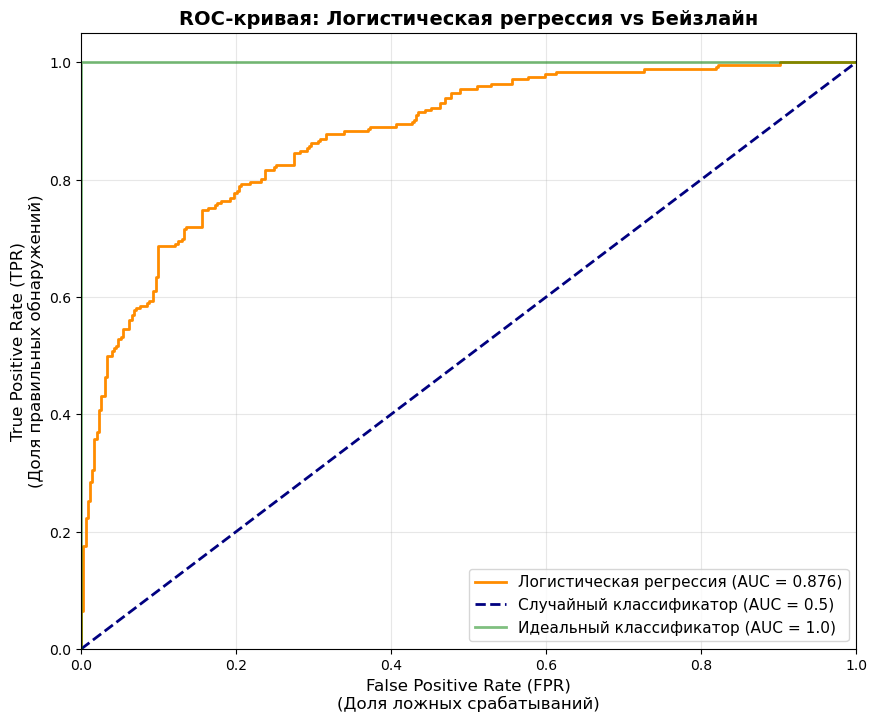

In [139]:
# Создаем график
plt.figure(figsize=(10, 8))

# ROC-кривая для логистической регрессии
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'Логистическая регрессия (AUC = {roc_auc:.3f})')

# ROC-кривая для бейзлайн модели
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
         label='Случайный классификатор (AUC = 0.5)')

# ROC-кривая для идеального классификатора
plt.plot([0, 0, 1], [0, 1, 1], color='green', lw=2, linestyle='-', 
         alpha=0.5, label='Идеальный классификатор (AUC = 1.0)')

# Настройка графика
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)\n(Доля ложных срабатываний)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)\n(Доля правильных обнаружений)', fontsize=12)
plt.title('ROC-кривая: Логистическая регрессия vs Бейзлайн', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)


import os
filename = os.path.join("figures", "roc_curve.png")
plt.savefig(filename, dpi=300, bbox_inches='tight')

plt.show()

<Figure size 640x480 with 0 Axes>